<a href="https://colab.research.google.com/github/jejjohnson/research_notebook/blob/main/research_notebook/content/notes/egps/notebooks/gpjax_egp_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MCMC + Sigma Points Demo

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [1]:
#@title Install  
try:
    import gpjax
    import numpyro
    import chex

except ModuleNotFoundError:
    import os
    os.system("pip install arviz chex loguru")
    os.system("pip install git+https://github.com/thomaspinder/GPJax.git#egg=GPJAX")
    
finally:
    # import library functions
    import gpjax
    import numpyro

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random

import gpjax


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext autoreload
%autoreload 2

## Demo Data

In [3]:
key = jax.random.PRNGKey(123)
y_noise = 0.05
x_noise = 0.5

f = lambda x: jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * x))
ntrain = 60

X = np.linspace(-10, 10, ntrain).reshape(-1, 1)

key, y_rng = jax.random.split(key, 2)
y = f(X)

# Noisy Signal

key, x_rng = jax.random.split(key, 2)

X_noise = X + x_noise * jax.random.normal(x_rng, shape=X.shape)
y_noise = f(X) + y_noise * jax.random.normal(y_rng, shape=X.shape)

# sort inputs
idx_sorted = jnp.argsort(X_noise, axis=0).squeeze()

X_noise = X_noise[(idx_sorted,)]
y_noise = y_noise[(idx_sorted,)]
X = X[(idx_sorted,)]
y = y[(idx_sorted,)]

ntest = 100


Xtest = np.linspace(-10.1, 10.1, ntest)[:, None]

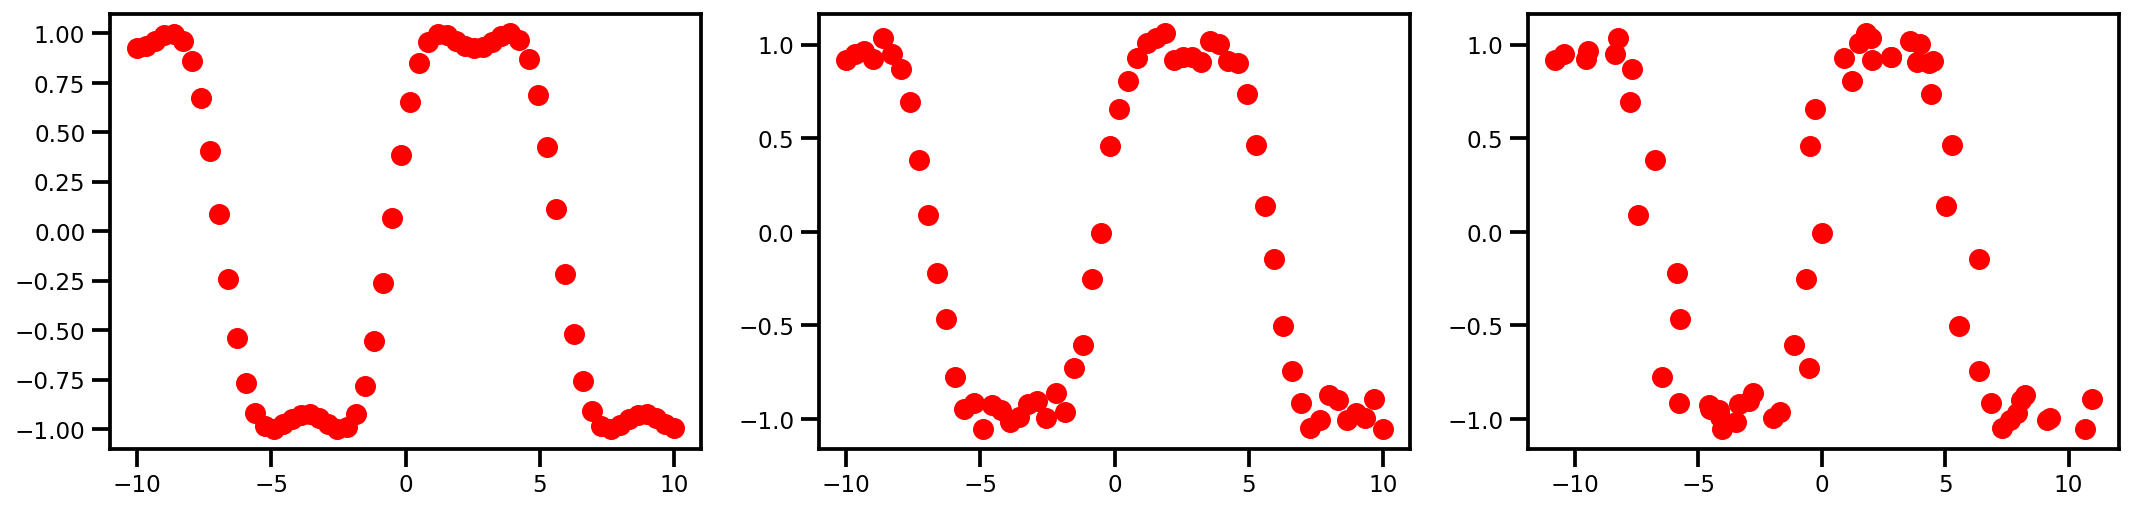

In [4]:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
ax[0].scatter(X, y, color='red')
ax[1].scatter(X, y_noise, color='red')
ax[2].scatter(X_noise, y_noise, color='red')
plt.show()

## Standard GP Model

### Model

In [5]:
from gpjax.gps import Prior
from gpjax.mean_functions import Zero
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian
from gpjax.types import Dataset



# GP Prior
mean_function = Zero()
kernel = RBF()
prior = Prior(mean_function=mean_function, kernel=kernel)

# GP Likelihood
lik = Gaussian()

# GP Posterior
posterior = prior * lik

# initialize training dataset
training_ds = Dataset(X=X, y=y_noise)

#### Parameters

In [6]:
from gpjax.parameters import initialise
import numpyro.distributions as dist
from gpjax.interfaces.numpyro import numpyro_dict_params, add_constraints


# initialize parameters
params = initialise(posterior)

hyperpriors = {
    "lengthscale": dist.LogNormal(0.0, 10.0),
    "variance": dist.LogNormal(0.0, 10.0),
    "obs_noise": dist.LogNormal(0.0, 10.0),
}

hyperpriors = {
    "lengthscale": 1.0,
    "variance": 1.0,
    "obs_noise": 0.01,
}


# convert to numpyro-style params
numpyro_params = numpyro_dict_params(hyperpriors)

# convert to numpyro-style params
numpyro_params = add_constraints(numpyro_params, dist.constraints.softplus_positive)

### Inference (SVI)

In [7]:
from numpyro.infer.autoguide import AutoDelta
from gpjax.interfaces.numpyro import numpyro_marginal_ll, numpyro_dict_params


# initialize numpyro-style GP model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# approximate posterior
guide = AutoDelta(npy_model)

### Training

In [8]:
from numpyro.infer import SVI, Trace_ELBO

# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 2_000


# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.005)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), n_iterations, training_ds)

100%|██████████| 2000/2000 [00:04<00:00, 435.07it/s, init loss: -1145.6521, avg. loss [1901-2000]: -2827.7780]


#### Losses

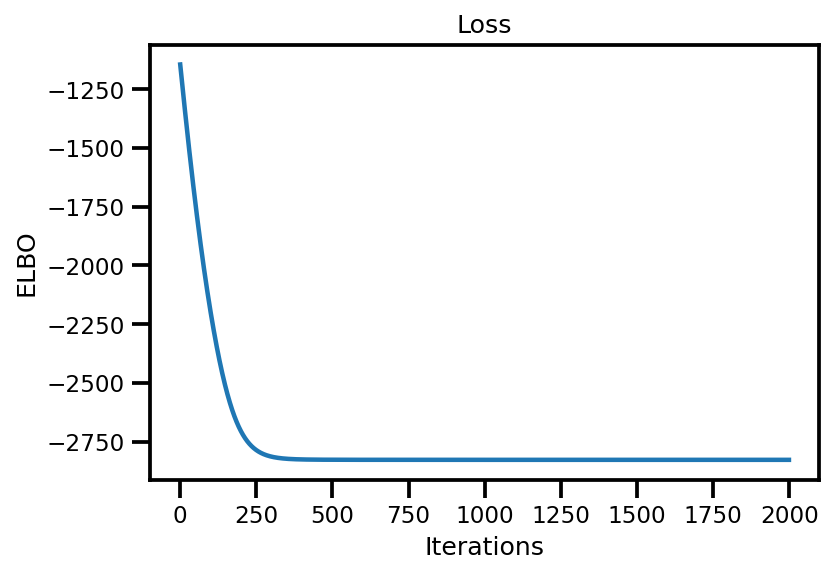

In [9]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

# Take them directly


In [10]:
learned_params = svi_results.params
learned_params

{'lengthscale': DeviceArray(1.735, dtype=float64),
 'obs_noise': DeviceArray(0.003, dtype=float64),
 'variance': DeviceArray(0.656, dtype=float64)}

In [11]:
from gpjax import mean, variance

meanf = mean(posterior, learned_params, training_ds)
covarf = variance(posterior, learned_params, training_ds)
varf = lambda x: jnp.atleast_1d(jnp.diag(covarf(x)))


mu = meanf(Xtest).squeeze()
cov = covarf(Xtest).squeeze()
var = varf(Xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

In [12]:
def get_sorted_indices(X):
    return jnp.argsort(X, axis=0).squeeze()

def apply_sorted_indices(X, sorted_idx):
    return X[(sorted_idx,)]

In [13]:
def plot_1D_GP_clean(Xtest, y_mu, y_var):

    one_stddev = 1.96 * jnp.sqrt(y_var)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(X.ravel(), y.squeeze(), "o", color="tab:orange")

    ax.plot(Xtest.ravel(), y_mu, color="tab:blue")
    ax.fill_between(
        Xtest.ravel(),
        y_mu.ravel() - one_stddev.ravel(),
        y_mu.ravel() + one_stddev.ravel(),
        alpha=0.4,
        color="tab:blue",
    )
    ax.plot(Xtest.ravel(), y_mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
    ax.plot(Xtest.ravel(), y_mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
    plt.show()
    return fig, ax

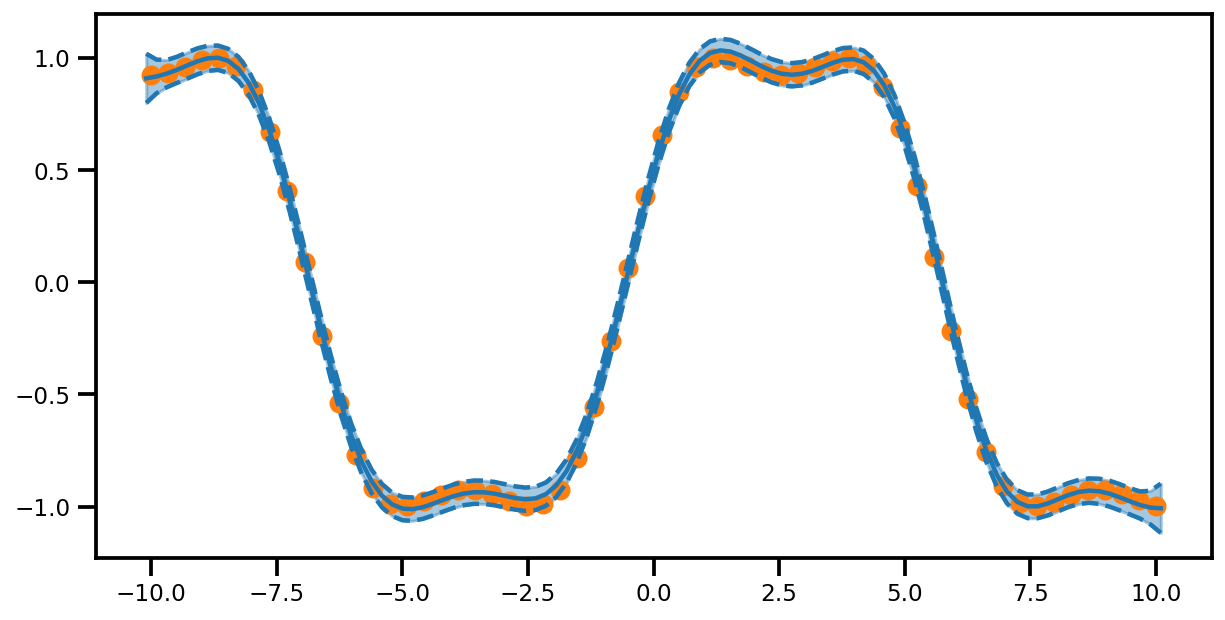

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5e214b6950>)

In [14]:
plot_1D_GP_clean(Xtest, mu, jnp.diag(cov))

### Predictions on Noisy Data

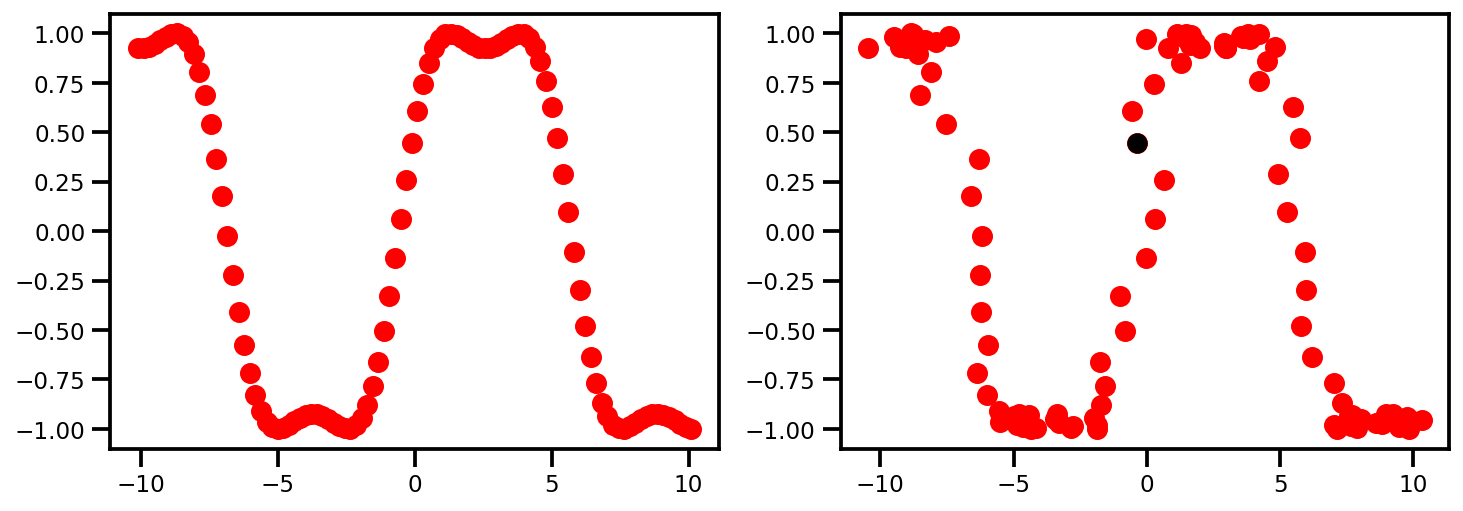

In [15]:
x_noise = 0.5
input_cov = jnp.array([x_noise]).reshape(-1, 1) ** 2

ntest = 100


Xtest = np.linspace(-10.1, 10.1, ntest)[:, None]
ytest = f(Xtest) 

demo_sample_idx = 47

key, xt_rng = jax.random.split(key, 2)

Xtest_noisy = Xtest + x_noise * jax.random.normal(xt_rng, shape=Xtest.shape)


idx_sorted = jnp.argsort(Xtest_noisy, axis=0)

# Xtest = Xtest[(idx_sorted,)]
Xtest_noisy = Xtest_noisy[(idx_sorted,)][..., 0]
ytest_noisy = ytest[(idx_sorted,)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[1].scatter(Xtest_noisy, ytest_noisy, color='red')
ax[0].scatter(Xtest, ytest, color='red')
ax[1].scatter(Xtest_noisy[demo_sample_idx], ytest_noisy[demo_sample_idx], marker=".", s=300, color="black")

plt.show()

In [16]:
def plot_1D_GP_noisy(Xtest_noisy, y_mu, y_var):

    one_stddev = 1.96 * jnp.sqrt(y_var)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(Xtest_noisy.squeeze(), ytest_noisy.squeeze(), "o", color="tab:orange")

    ax.plot(Xtest_noisy.squeeze(), y_mu.squeeze(), color="tab:blue")
    ax.fill_between(
        Xtest_noisy.squeeze(),
        y_mu.squeeze() - one_stddev.squeeze(),
        y_mu.ravel() + one_stddev.squeeze(),
        alpha=0.4,
        color="tab:blue",
    )
    ax.plot(Xtest_noisy.squeeze(), y_mu.squeeze() - one_stddev.squeeze(), linestyle="--", color="tab:blue")
    ax.plot(Xtest_noisy.squeeze(), y_mu.squeeze() + one_stddev.squeeze(), linestyle="--", color="tab:blue")
    plt.show()
    return fig, ax

In [17]:
mu = meanf(Xtest_noisy).squeeze()
var = varf(Xtest_noisy).squeeze()


one_stddev = 1.96 * jnp.sqrt(var)

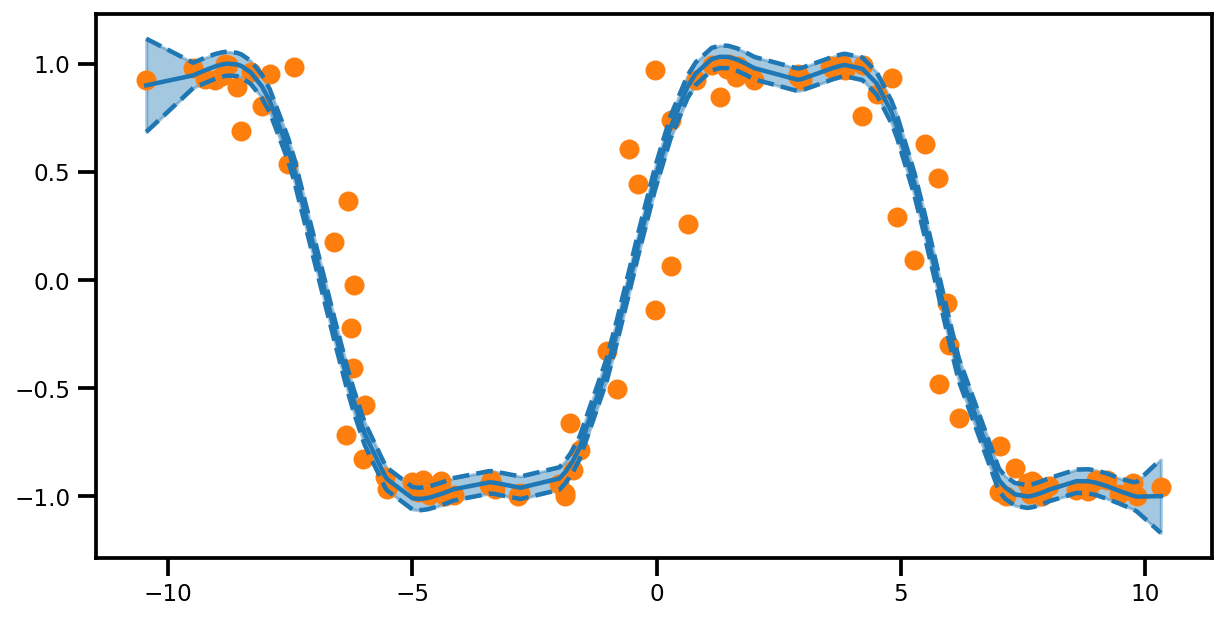

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5e20127390>)

In [18]:
plot_1D_GP_noisy(Xtest_noisy, mu, var)

## Noisy Test Samples

In Gaussian processes, the original formulation dictates that we assume there is some noise in the observations, $y$ and that we observe the real inputs $\mathbf{x}$. So we'll see that this it is not trivial to modify this formulation to account for uncertain inputs. Let's assume that we have a data set $\mathcal{D}=\{\mathbf{X}, \boldsymbol{y} \}$. In this case we assume the following relationship between our inputs, $\mathbf{x}$, and outputs, $y$:

$$
\begin{aligned}
y_n &= f(\mathbf{x}_n)+ \epsilon_y \\
\epsilon_y &\sim \mathcal{N}(0,\sigma_y^2)
\end{aligned}
$$

Let's also assume that we have a standard GP model optimized and fitted to this data set. We're not assuming noisy inputs during the training phase so we will use the standard log-likelihood maximization procedure. However, during the testing phase, we will assume that our inputs are noisy. For simplicity, we can assume our test data set is normally distributed with a mean $\mu_\mathbf{x}$ and variance $\Sigma_\mathbf{x}$. So we will have:

$$
\mathbf{x}_* \sim \mathcal{N}(\mu_\mathbf{x}, \Sigma_\mathbf{x}) $$

or equivalently we can reparameterize it like so:

$$
\begin{aligned}
\mathbf{x}_* &=\mu_\mathbf{x}+ \epsilon_\mathbf{x} \\
\epsilon_\mathbf{x} &\sim \mathcal{N}(0, \Sigma_\mathbf{x})
\end{aligned}
$$

If we consider the predictive distribution given by $p(f_*|\mathbf{x}_*, \mathcal{D})$,  we need to marginalize out the input distribution. So the full integral appears as follows.

$$p(f_*|\mu_\mathbf{x}, \Sigma_\mathbf{x},\mathcal{D}) = \int p(f_*|\mathbf{x}_*,\mathcal{D})\;\mathcal{N}(\mathbf{x}_*|\mu_\mathbf{x},\Sigma_\mathbf{x})\; d\mathbf{x}_*$$

If we use the GP formulation, we have a closed-form deterministic predictive distribution for $p(f_*|\mathbf{x}_*,\mathcal{D})$. Plugging this into the above equation gives us:

$$p(f_*|\mu_\mathbf{x},\Sigma_\mathbf{x},\mathcal{D}) = \int \mathcal{N}\left(f_*|\mu_\mathcal{GP}(\mathbf{x}_*),\sigma^2_\mathcal{GP}(\mathbf{x}_*) \right) \; \mathcal{N}(\mathbf{x}_*|\mu_\mathbf{x}, \Sigma_\mathbf{x})\; d\mathbf{x}_*$$

So this integral is intractable because if we consider the terms within the GP predictive mean and predictive variance, we will need to calculate the integral of an inverse kernel function, $\mathbf{K}_\mathcal{GP}^{-1}$. Below we outline some of the most popular methods found in the literature.

### Demo - Single Point

For to demonstrate the function, we're going to do the steps assuming no batch dimension. In other words, we're working with a test vector $\mathbf{x}_* \in \mathbb{R}^{D}$, **not** a matrix of samples $\mathbf{X}_* \in \mathbb{R}^{N\times D}$.

In [19]:
xtest_noisy = Xtest_noisy[demo_sample_idx]
mu_demo = {}

mu_demo = {
    "standard": meanf(xtest_noisy)
}
covar_demo = {
    "standard": varf(xtest_noisy)
}

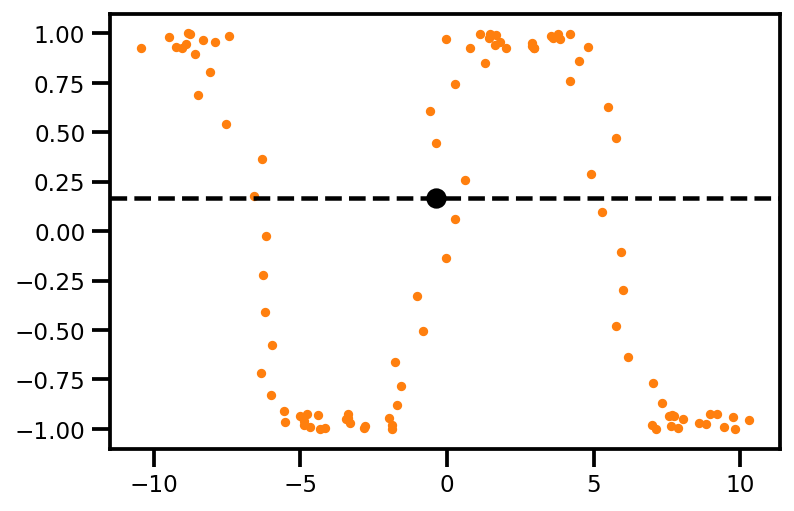

In [20]:
plt.scatter(Xtest_noisy, ytest_noisy, s=10, color="tab:orange")
plt.scatter(xtest_noisy, mu_demo["standard"], marker=".", s=300, color="black")
plt.axhline(mu_demo["standard"], linestyle="--", color="black")

In [21]:
# x_mu = np.array([-0.2])
# x_cov = np.tile(np.diag(np.array([3.0])), (1, 1))

# # get function
# f = jax.vmap(jax.partial(predictive_mean, model))
# df = jax.vmap(jax.grad(jax.partial(predictive_mean, model)))

In [22]:
# mu = f(Xtest)

# # plt.hist(x_mc_samples.squeeze(), bins=100, density=True);
# fig, ax = plt.subplots(figsize=(7, 5))
# ax.plot(Xtest, mu, color='red', linewidth=4, label=r"$f(x)$")
# ax.axvline(x_sample, linestyle="--", color='black', linewidth=4)
# ax.set(xticklabels="", xlabel="", yticklabels="")
# plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.2)
# ax.set(xlim=(-10, 10), ylim=(-2.1, 2.1))
# plt.scatter(X, y, label='Training', color='blue', s=60, zorder=3)
# plt.legend(fontsize=15)
# plt.show()

### Monte Carlo Sampling

In this first example, we will approximate the actual posterior using Monte Carlo sampling. Using the following formula:

$$
p(f_*|\mu_\mathbf{x}, \Sigma_\mathbf{x}, \mathcal{D}) \approx \frac{1}{T}\sum_{t=1}^T \mathcal{N}\left(f_*|\mu_\mathcal{GP}(\mathbf{x}_*^t),\sigma^2_\mathcal{GP}(\mathbf{x}_*^t) \right) 
$$

This will approach the real posterior as $T$ grows. What we want to demonstrate is that this posterior is non-Gaussian when our inputs are non-Gaussian.

In this example, we assume that $\mathbf{x}_* \sim \mathcal{N}(\mathbf{\mu_x}, \mathbf{\Sigma_x})$. We're assuming our data points come We can reparameterize this as f


we will be using the following form to do the sampling:

$$
\mathbf{x}_T = \mu_\mathbf{x} + \mathbf{L}\mathbf{z}
$$

where $\mathbf{z}\sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. So we will draw 10,000 samples and then propagate all of these through the non-linear function.

In [23]:
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions

n_features = 1

z = dist.Normal(loc=np.zeros((n_features,)), scale=np.ones(n_features))

In [24]:


# input covariance
L = jnp.linalg.cholesky(input_cov)

chex.assert_shape(L, (n_features, n_features,))

# generate sigma points
n_mc_points = 100
sigma_pts = z.sample((n_mc_points,), key).T

chex.assert_shape(sigma_pts, (n_features, n_mc_points,))

# calculate sigma points
x_mc_samples = xtest_noisy + L @ sigma_pts

chex.assert_shape(x_mc_samples, (n_features, n_mc_points))

# mean function predictions

f = lambda x: jnp.atleast_1d(meanf(x).squeeze())

y_mu_mc = jax.vmap(f, in_axes=2)(x_mc_samples[:, None, :])

y_mu_mc = jnp.atleast_1d(y_mu_mc)

chex.assert_shape(y_mu_mc, (n_mc_points, n_features,))


# calculate mean of MC samples
wm = 1.0 / n_mc_points
y_mu = jnp.mean(y_mu_mc, axis=0)

chex.assert_shape(y_mu, (n_features,))

# calculate covariance of MC samples
wc = 1.0 / (n_mc_points - 1.0)
dfx = y_mu_mc - y_mu

chex.assert_shape(dfx, (n_mc_points, n_features,))

x_cov = wc * dfx.T @ dfx

chex.assert_shape(x_cov, (n_features, n_features,))

# input-output covariance
x_covx = wc * (x_mc_samples - xtest_noisy) @ dfx

chex.assert_shape(x_cov, (n_features, n_features,))

In [25]:
mu_demo["mc"] = y_mu

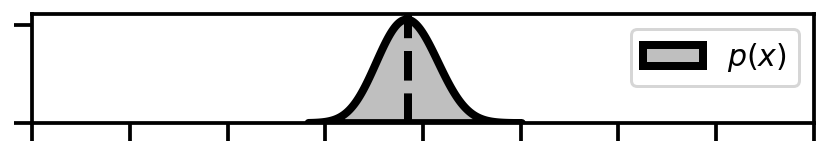

In [26]:
# plt.hist(x_mc_samples.squeeze(), bins=100, density=True);
fig, ax = plt.subplots(figsize=(7, 1))
sns.kdeplot(ax=ax, x=x_mc_samples.squeeze(), bw_adjust=3., color='black', linewidth=4, fill=True, label=r"$p(x)$")
ax.axvline(xtest_noisy, linestyle="--", color='black', linewidth=4)
ax.set(yticklabels="", ylabel="", xticklabels="", xlim=(-10, 10))
# ax.set_ylim(-1.5, 1.1)
plt.legend(fontsize=15)
plt.show()

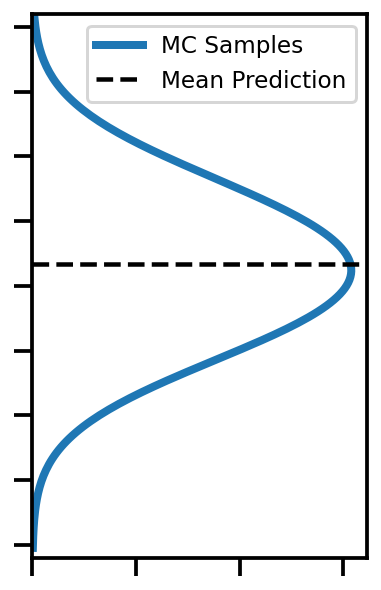

In [27]:
fig, ax = plt.subplots(figsize=(3,5))
sns.kdeplot(ax=ax, y=y_mu_mc.ravel(), bw_adjust=3., linewidth=4,  label='MC Samples')
ax.set(xlabel="", xticklabels="", ylim=(-2.1, 2.1), yticklabels="")
ax.axhline(mu_demo["standard"], color="black", linestyle="--", label="Mean Prediction")
plt.legend()
plt.show()

#### Vectorized Over All Samples

In [84]:
from typing import Callable

def init_mc_moment_transform(
    meanf: Callable, 
    n_features: int, 
    mc_samples: int=100,
    covariance: bool=False
    )-> Callable:


    f = lambda x: jnp.atleast_1d(meanf(x).squeeze())
    z = dist.Normal(loc=np.zeros((n_features,)), scale=np.ones(n_features))
    wm = 1.0 / mc_samples
    wc = 1.0 / (mc_samples - 1.0)

    def apply_transform(rng_key, x, x_cov):

        # sigma points
        sigma_pts = z.sample((mc_samples,), key)

        # cholesky for input covariance
        L = jnp.linalg.cholesky(input_cov)

        # calculate sigma points
        x_mc_samples = x + L @ sigma_pts.T

        # ===================
        # Mean
        # ===================

        # function predictions over mc samples
        y_mu_mc = jax.vmap(f, in_axes=1)(x_mc_samples)
        
        y_mu_mc = y_mu_mc.reshape((mc_samples, n_features,)) 

        # mean of mc samples
        y_mu = jnp.mean(y_mu_mc, axis=0).reshape(-1)

        # ===================
        # Covariance
        # ===================
        dfydx = y_mu_mc - y_mu

        y_cov = wc * dfydx.T @ dfydx

        if not covariance:
            y_cov = jnp.diag(y_cov).reshape(-1)

        return y_mu, y_cov
        
    return apply_transform

In [83]:
jnp.ones(shape=(10, 10)).reshape(-1, 1).shape

(10, 10)

In [85]:
# init function
n_features = 1
mc_samples = 1_000
mc_transform = init_mc_moment_transform(meanf, n_features=n_features, mc_samples=mc_samples)

# apply function
xtest_noisy = Xtest_noisy[demo_sample_idx][..., 0]
input_cov = jnp.array([x_noise]).reshape(-1, 1)

x_mu, x_var = mc_transform(key, xtest_noisy, input_cov)

chex.assert_equal_shape([x_mu, x_var])
chex.assert_shape(x_mu, (n_features,))

In [86]:
mc_transform_vectorized = jax.jit(jax.vmap(mc_transform, in_axes=(None, 0, None)))

In [87]:
y_mu, y_var = mc_transform_vectorized(key, Xtest_noisy, input_cov)

chex.assert_equal_shape([y_mu, y_var])
chex.assert_shape(y_mu, (ntest, n_features,))

y_std = 1.96 * jnp.sqrt(y_var)

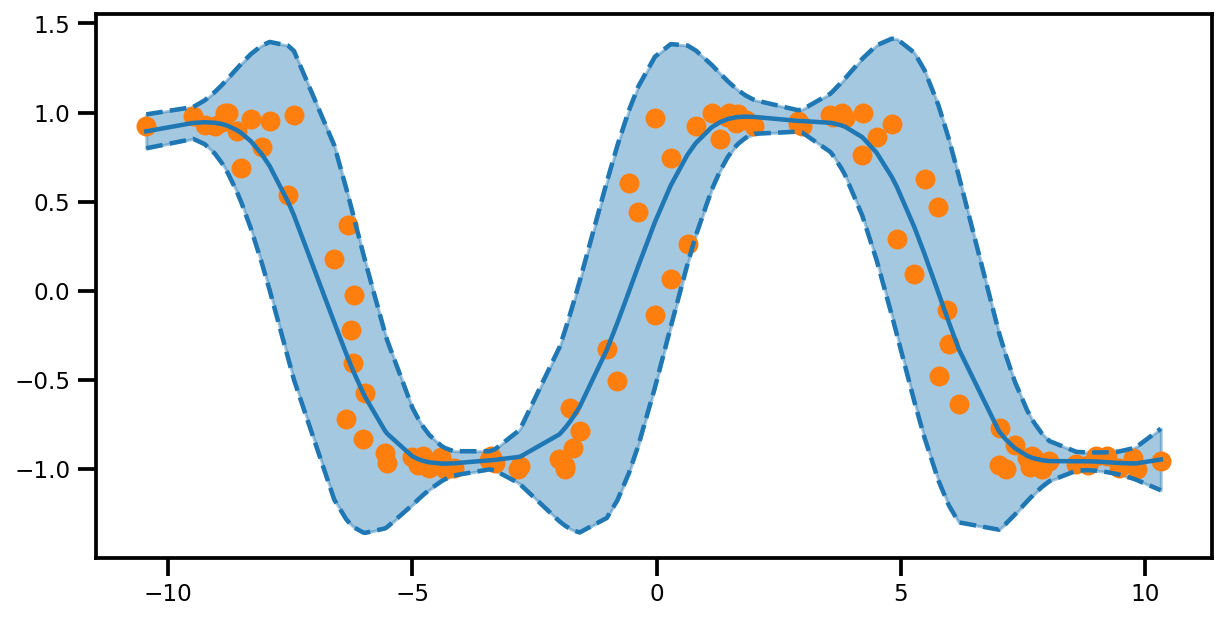

In [88]:
plot_1D_GP_noisy(Xtest_noisy, y_mu, y_var);

As you can see, this is a non-Gaussian distribution. Below we will see how we can approximate this as a Gaussian.

## Unscented Transformation

#### Unscented Weights

In [47]:
from typing import Optional, Tuple

def get_unscented_weights(
    n_features: int,
    kappa: Optional[float] = None,
    alpha: float = 1.0,
    beta: float = 2.0,
) -> Tuple[float, float]:
    """Generate normalizers for MCMC samples"""

    # calculate kappa value
    if kappa is None:
        kappa = jnp.maximum(3.0 - n_features, 0.0)

    lam = alpha ** 2 * (n_features + kappa) - n_features
    wm = 1.0 / (2.0 * (n_features + lam)) * np.ones(2 * n_features + 1)
    wc = wm.copy()
    wm = jax.ops.index_update(wm, 0, lam / (n_features + lam))
    wc = jax.ops.index_update(wc, 0, wm[0] + (1 - alpha ** 2 + beta))
    return wm, wc

In [48]:
n_features = 1
alpha = 1.0
beta = 2.0
kappa = None
n_sigma_points = 3

wm, wc = get_unscented_weights(n_features, kappa, alpha, beta)

chex.assert_equal_shape([wm, wc])
chex.assert_shape(wm, (n_sigma_points,))

# Wm, Wc = jnp.diag(wm), jnp.diag(wc)

# chex.assert_equal_shape([Wm, Wc])
# chex.assert_shape(Wm, (n_sigma_points,n_sigma_points))

Wm, Wc = wm, jnp.diag(wc)

chex.assert_shape(Wc, (n_sigma_points, n_sigma_points))
chex.assert_shape(Wm, (n_sigma_points,))

#### Sigma Points

In [49]:
def get_unscented_sigma_points(
    n_features: int, kappa: Optional[float] = None, alpha: float = 1.0
) -> Tuple[chex.Array, chex.Array]:
    """Generate Unscented samples"""

    # calculate kappa value
    if kappa is None:
        kappa = np.maximum(3.0 - n_features, 0.0)

    lam = alpha ** 2 * (n_features + kappa) - n_features
    c = np.sqrt(n_features + lam)
    return np.hstack(
        (np.zeros((n_features, 1)), c * np.eye(n_features), -c * np.eye(n_features))
    )

In [53]:
kappa = None
alpha = 1.0
n_features = 1
n_sigma_points = 2 * n_features + 1


# generate sigma points
sigma_pts = get_unscented_sigma_points(n_features, kappa, alpha)

chex.assert_equal_shape([sigma_pts, sigma_pts])

In [54]:

# input covariance
L = jnp.linalg.cholesky(input_cov)

chex.assert_shape(L, (n_features, n_features,))

# calculate sigma points
x_sigma_samples = xtest_noisy + L @ sigma_pts

chex.assert_shape(x_sigma_samples, (n_features, n_sigma_points))

# mean function predictions

f = lambda x: jnp.atleast_1d(meanf(x).squeeze())

y_mu_unc = jax.vmap(f, in_axes=2)(x_sigma_samples[:, None, :])

y_mu_unc = jnp.atleast_1d(y_mu_unc)

chex.assert_shape(y_mu_unc, (n_sigma_points, n_features,))

# calculate weights of unscented points
y_mu = y_mu_unc.T @ Wm



chex.assert_shape(y_mu, (n_features,))

# calculate covariance of MC samples
dfx = y_mu_unc - y_mu

chex.assert_shape(dfx, (n_sigma_points, n_features,))

y_cov = dfx.T @ Wc @ dfx

chex.assert_shape(y_cov, (n_features, n_features,))

# input-output covariance
y_covx = wc * (x_sigma_samples - xtest_noisy) @ dfx

chex.assert_shape(y_cov, (n_features, n_features,))

In [55]:
mu_demo["sigma"] = y_mu

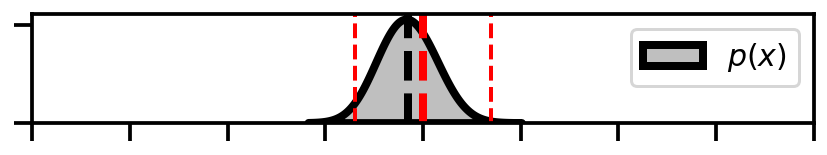

In [56]:
# plt.hist(x_mc_samples.squeeze(), bins=100, density=True);
fig, ax = plt.subplots(figsize=(7, 1))
sns.kdeplot(ax=ax, x=x_mc_samples.squeeze(), bw_adjust=3., color='black', linewidth=4, fill=True, label=r"$p(x)$")
ax.axvline(xtest_noisy, linestyle="--", color='black', linewidth=4)
ax.axvline(sigma_pts[:, 0], linestyle="--", color='red', linewidth=4)
ax.axvline(sigma_pts[:, 1], linestyle="--", color='red', linewidth=2)
ax.axvline(sigma_pts[:, 2], linestyle="--", color='red', linewidth=2)
ax.set(yticklabels="", ylabel="", xticklabels="", xlim=(-10, 10))
# ax.set_ylim(-1.5, 1.1)
plt.legend(fontsize=15)
plt.show()

In [57]:
# generate samples from the distribution
unscented_samples = jax.random.multivariate_normal(key, jnp.atleast_1d(y_mu),  y_cov, (n_mc_points,))

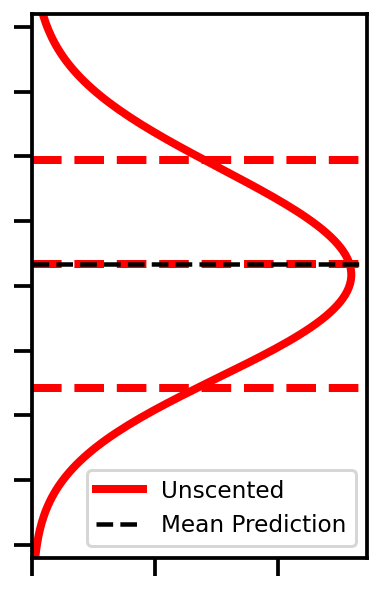

In [58]:
fig, ax = plt.subplots(figsize=(3,5))
sns.kdeplot(ax=ax, y=unscented_samples.ravel(), bw_adjust=3., linewidth=4,  color="red", label='Unscented')
ax.set(xlabel="", xticklabels="", ylim=(-2.1, 2.1), yticklabels="")
ax.axhline(y_mu_unc[0], linestyle="--", color='red', linewidth=4)
ax.axhline(y_mu_unc[1], linestyle="--", color='red', linewidth=4)
ax.axhline(y_mu_unc[2], linestyle="--", color='red', linewidth=4)
ax.axhline(mu_demo["standard"], color="black", linestyle="--", label="Mean Prediction")
plt.legend()
plt.show()

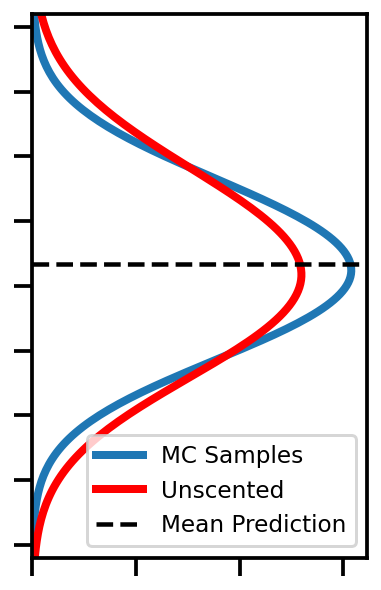

In [59]:
fig, ax = plt.subplots(figsize=(3,5))
sns.kdeplot(ax=ax, y=y_mu_mc.ravel(), bw_adjust=3., linewidth=4,  label='MC Samples')
sns.kdeplot(ax=ax, y=unscented_samples.ravel(), bw_adjust=3., linewidth=4,  color="red", label='Unscented')
ax.set(xlabel="", xticklabels="", ylim=(-2.1, 2.1), yticklabels="")
ax.axhline(mu_demo["standard"], color="black", linestyle="--", label="Mean Prediction")
plt.legend()
plt.show()

### Vectorized Demo

In [92]:
from typing import Callable

def init_unscented_transform(
    meanf: Callable, 
    n_features: int, 
    alpha: float=1.0,
    beta: float=2.0,
    kappa: Optional[float]=None,
    covariance: bool=False
    )-> Callable:


    f = lambda x: jnp.atleast_1d(meanf(x).squeeze())

    # get weights
    wm, wc = get_unscented_weights(n_features, kappa, alpha, beta)

    Wm, Wc = wm, jnp.diag(wc)

    # generate sigma points
    sigma_pts = get_unscented_sigma_points(n_features, kappa, alpha)

    def apply_transform(x, x_cov):

        # cholesky decomposition
        L = jnp.linalg.cholesky(x_cov)

        # calculate sigma points
        x_sigma_samples = x + L @ sigma_pts


        # propagate samples through function
        y_mu_unc = jax.vmap(f, in_axes=2)(x_sigma_samples[:, None, :])

        y_mu_unc = y_mu_unc.reshape(-1, 1)

        # ===================
        # Mean
        # ===================

        # calculate weights of unscented points
        y_mu = y_mu_unc.T @ Wm

        # ===================
        # Covariance
        # ===================

        # calculate covariance of MC samples
        dfx = y_mu_unc - y_mu

        y_cov = dfx.T @ Wc @ dfx


        if not covariance:
            y_cov = jnp.diag(y_cov).reshape(-1)

        return y_mu, y_cov
        
    return apply_transform

In [93]:
# init function
unscented_transform = init_unscented_transform(meanf, 1)

# apply function
xtest_noisy = Xtest_noisy[demo_sample_idx]
input_cov = jnp.array([x_noise]).reshape(-1, 1)

y_mu, y_var = unscented_transform(xtest_noisy, input_cov)

chex.assert_equal_shape([y_mu, y_var])
chex.assert_shape(y_mu, (n_features,))

In [94]:
unscented_transform_vectorized = jax.jit(jax.vmap(unscented_transform, in_axes=(0, None)))

In [97]:
y_mu, y_var = unscented_transform_vectorized(Xtest_noisy, input_cov)

chex.assert_equal_shape([y_mu, y_var])
chex.assert_shape(y_mu, (ntest, n_features,))

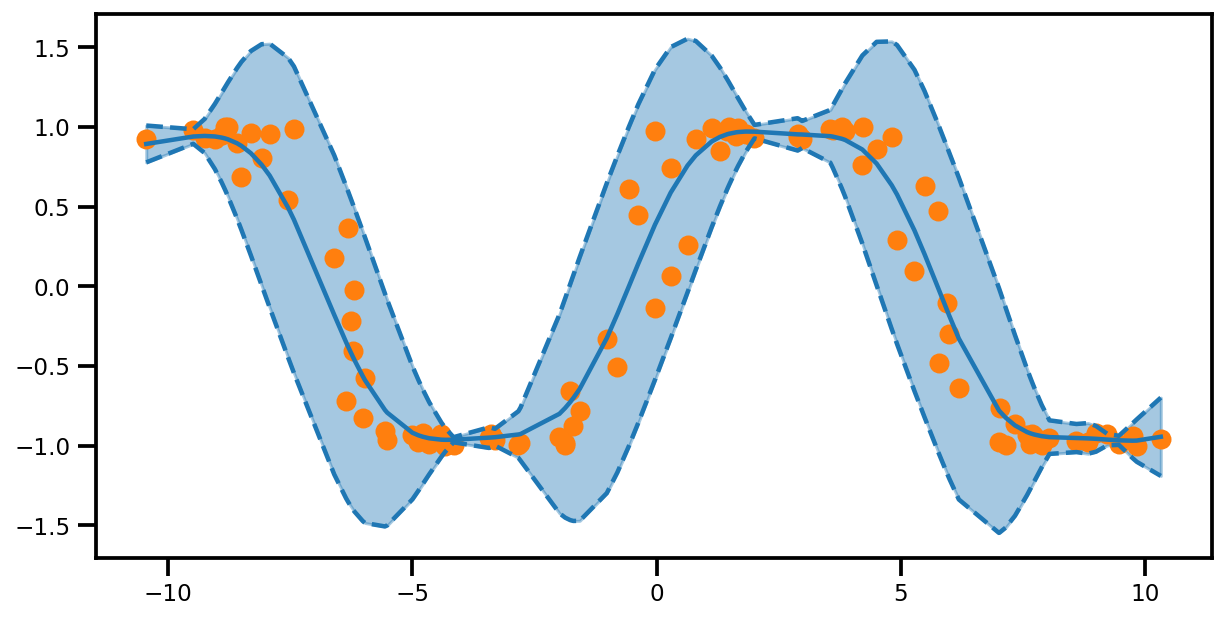

In [98]:
# y_var = var.squeeze() + y_var_o2.squeeze()

plot_1D_GP_noisy(Xtest_noisy, y_mu, y_var);